# Imports & Utility Functions

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost as xgb

# pytorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# explainability
import shap

In [2]:
# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda


In [3]:
# utility plotting function
def plot_conf_matrix(y_true, y_pred, labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Load dataset

In [4]:

df = pd.read_csv('/kaggle/input/heart-disease-data/heart_disease_uci.csv')
print('Rows, cols:', df.shape)

Rows, cols: (920, 16)


In [5]:
# quick peek
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [6]:
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
print("\nBinary Target distribution:\n", df['num'].value_counts())


Binary Target distribution:
 num
1    509
0    411
Name: count, dtype: int64


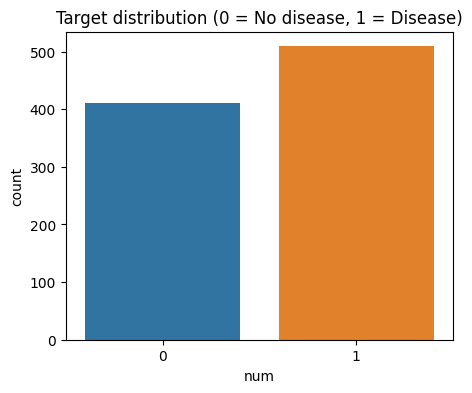

In [7]:
# target distribution
plt.figure(figsize=(5,4))
sns.countplot(x=df['num'])
plt.title('Target distribution (0 = No disease, 1 = Disease)')
plt.show()

In [8]:
# ## 2. Exploratory Data Analysis (EDA)
print(df.info())
print('\nMissing values per column:\n', df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

Missing values per column:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59

In [9]:
# basic statistics
print(df.describe())

               id         age    trestbps        chol      thalch     oldpeak  \
count  920.000000  920.000000  861.000000  890.000000  865.000000  858.000000   
mean   460.500000   53.510870  132.132404  199.130337  137.545665    0.878788   
std    265.725422    9.424685   19.066070  110.780810   25.926276    1.091226   
min      1.000000   28.000000    0.000000    0.000000   60.000000   -2.600000   
25%    230.750000   47.000000  120.000000  175.000000  120.000000    0.000000   
50%    460.500000   54.000000  130.000000  223.000000  140.000000    0.500000   
75%    690.250000   60.000000  140.000000  268.000000  157.000000    1.500000   
max    920.000000   77.000000  200.000000  603.000000  202.000000    6.200000   

               ca         num  
count  309.000000  920.000000  
mean     0.676375    0.553261  
std      0.935653    0.497426  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    1.000000  
75%      1.000000    1.000000  
max      3.000

In [10]:
# ## 3. Preprocessing
X = df.drop(columns=['num','id','dataset'], errors='ignore')
y = df['num']

In [11]:
# Explicit categorical columns
cat_cols = ['sex','cp','fbs','restecg','exang','slope','thal','ca']
num_cols = [c for c in X.columns if c not in cat_cols]

In [12]:
# Fill missing values
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

print("Missing values after imputation:\n", X.isnull().sum())

Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [13]:
# ColumnTransformer for preprocessing
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

invalid value encountered in less


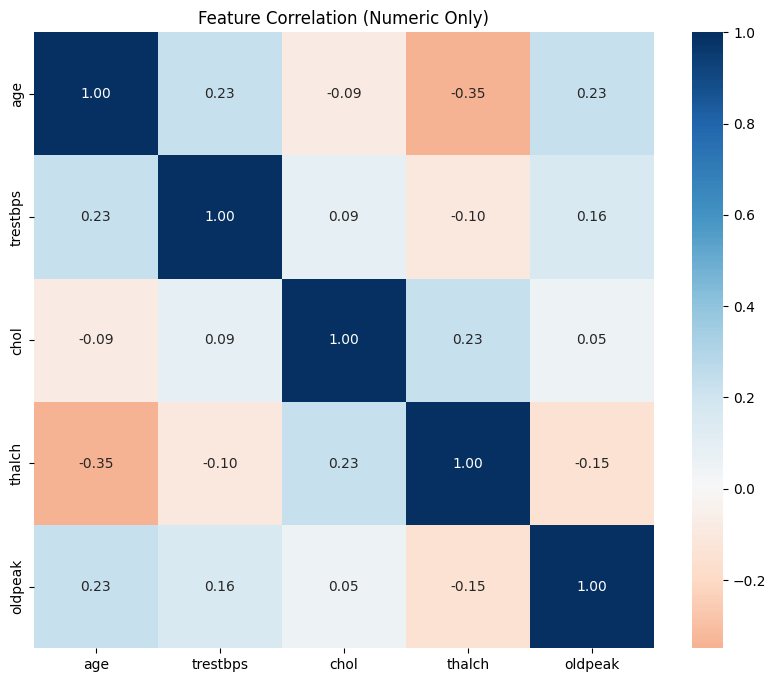

In [14]:
# Correlation heatmap (numeric columns only)
plt.figure(figsize=(10,8))
numeric_df = X[num_cols]
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='RdBu', center=0)
plt.title('Feature Correlation (Numeric Only)')
plt.show()

In [15]:
# Correlation with target
corr_target = numeric_df.copy()
corr_target['num'] = y
corr_target = corr_target.corr()['num'].sort_values(ascending=False)
print('Correlation with Target:\n', corr_target)

Correlation with Target:
 num         1.000000
oldpeak     0.366138
age         0.282700
trestbps    0.101273
chol       -0.228976
thalch     -0.381864
Name: num, dtype: float64


In [16]:
# Split train/val/test (70/15/15)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=SEED)

preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_val_t = preprocessor.transform(X_val)
X_test_t = preprocessor.transform(X_test)

In [17]:
# Get feature names
def get_feature_names(ct):
    num_feats = num_cols
    cat_feats = []
    if hasattr(ct.named_transformers_['cat']['onehot'], 'get_feature_names_out'):
        cat_feats = list(ct.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols))
    return num_feats + cat_feats

feature_names = get_feature_names(preprocessor)

print('Shapes after preprocessing:', X_train_t.shape, X_val_t.shape, X_test_t.shape)

Shapes after preprocessing: (643, 28) (139, 28) (138, 28)


RandomForest Accuracy: 0.8260869565217391
RandomForest ROC-AUC: 0.9073641765704583


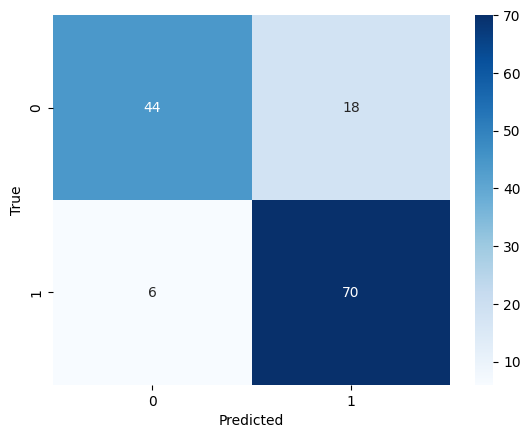

In [18]:
# ## 4. RandomForest

rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train_t, y_train)

y_pred_rf = rf.predict(X_test_t)
y_proba_rf = rf.predict_proba(X_test_t)[:,1]

print("RandomForest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
plot_conf_matrix(y_test, y_pred_rf)

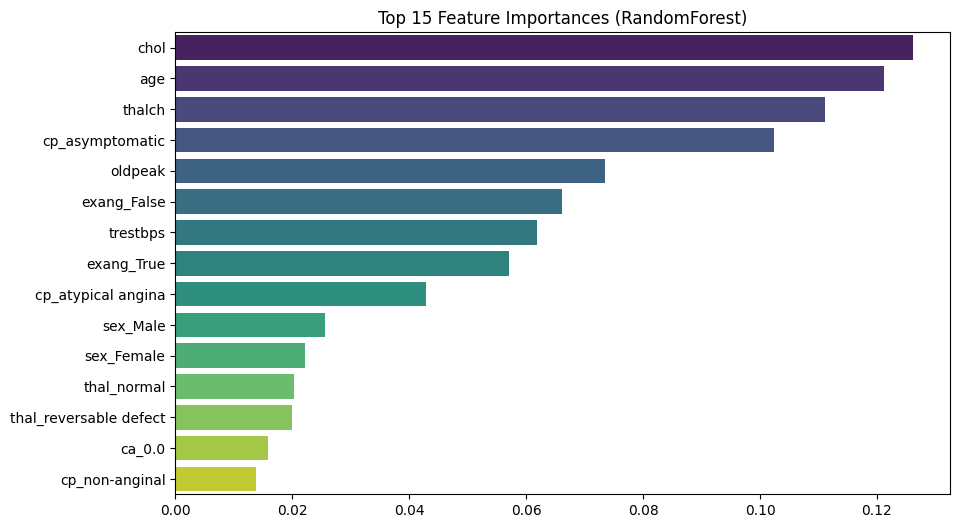

In [19]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances[:15], y=importances.index[:15], palette='viridis')
plt.title('Top 15 Feature Importances (RandomForest)')
plt.show()

XGBoost Accuracy: 0.855072463768116
XGBoost ROC-AUC: 0.8890067911714771


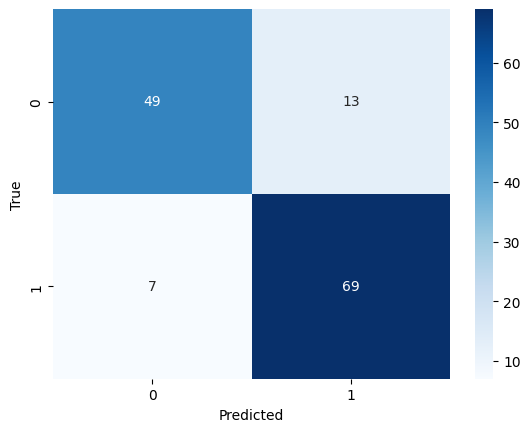

In [20]:

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=SEED)
xgb_model.fit(X_train_t, y_train)

y_pred_xgb = xgb_model.predict(X_test_t)
y_proba_xgb = xgb_model.predict_proba(X_test_t)[:,1]

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))
plot_conf_matrix(y_test, y_pred_xgb)

In [21]:
# ## 6. PyTorch Dataset & Dataloader

X_train_tensor = torch.tensor(X_train_t.todense() if hasattr(X_train_t, 'todense') else X_train_t, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_t.todense() if hasattr(X_val_t, 'todense') else X_val_t, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_t.todense() if hasattr(X_test_t, 'todense') else X_test_t, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

INPUT_DIM = X_train_tensor.shape[1]

In [22]:
# ## 7. PyTorch Model

class HeartDiseaseNN(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = HeartDiseaseNN(INPUT_DIM).to(DEVICE)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)


The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


In [23]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=12, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Epoch 1/200 — train_loss: 0.6510 — val_loss: 0.6300
Epoch 2/200 — train_loss: 0.5437 — val_loss: 0.5359
Epoch 3/200 — train_loss: 0.4615 — val_loss: 0.4890
Epoch 4/200 — train_loss: 0.4380 — val_loss: 0.4877
Epoch 5/200 — train_loss: 0.3935 — val_loss: 0.4678
Epoch 6/200 — train_loss: 0.3915 — val_loss: 0.4668
Epoch 7/200 — train_loss: 0.4261 — val_loss: 0.4599
Epoch 8/200 — train_loss: 0.3846 — val_loss: 0.4497
Epoch 9/200 — train_loss: 0.3647 — val_loss: 0.4574
Epoch 10/200 — train_loss: 0.3447 — val_loss: 0.4473
Epoch 11/200 — train_loss: 0.3739 — val_loss: 0.4524
Epoch 12/200 — train_loss: 0.3711 — val_loss: 0.4595
Epoch 13/200 — train_loss: 0.3510 — val_loss: 0.4472
Epoch 14/200 — train_loss: 0.3554 — val_loss: 0.4619
Epoch 15/200 — train_loss: 0.3498 — val_loss: 0.4494
Epoch 16/200 — train_loss: 0.3420 — val_loss: 0.4635
Epoch 17/200 — train_loss: 0.4163 — val_loss: 0.4646
Epoch 18/200 — train_loss: 0.3403 — val_loss: 0.4466
Epoch 19/200 — train_loss: 0.3342 — val_loss: 0.4467
Ep

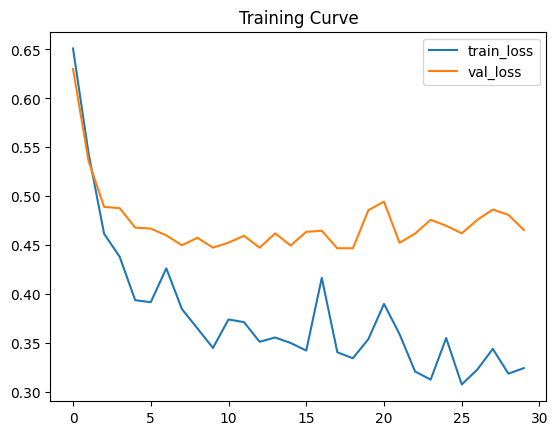

In [24]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=100):
    best_val_loss = float('inf')
    early_stopper = EarlyStopping(patience=12)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb)
                loss = loss_fn(preds, yb)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f} — val_loss: {val_loss:.4f}")

    model.load_state_dict(torch.load('best_model.pt'))
    return model, history

model, history = train_model(model, train_loader, val_loader, epochs=200)

plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training Curve')
plt.show()

PyTorch Test Accuracy: 0.8478260869565217
PyTorch ROC-AUC: 0.9087436332767402
              precision    recall  f1-score   support

         0.0       0.90      0.74      0.81        62
         1.0       0.82      0.93      0.87        76

    accuracy                           0.85       138
   macro avg       0.86      0.84      0.84       138
weighted avg       0.85      0.85      0.85       138



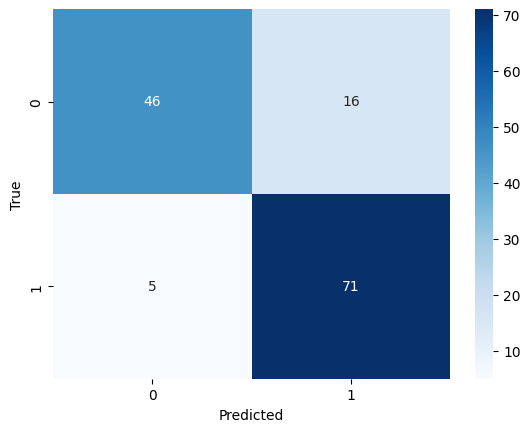

In [25]:
# ## 8. Evaluate PyTorch Model

model.eval()
all_preds, all_probs, all_targets = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        probs = model(xb).cpu().numpy().flatten()
        preds = (probs >= 0.5).astype(int)
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_targets.extend(yb.numpy().flatten().tolist())

print('PyTorch Test Accuracy:', accuracy_score(all_targets, all_preds))
print('PyTorch ROC-AUC:', roc_auc_score(all_targets, all_probs))
print(classification_report(all_targets, all_preds))
plot_conf_matrix(all_targets, all_preds)


In [26]:
# ## 9. Save Artifacts
import joblib
joblib.dump(preprocessor, 'preprocessor.joblib')
torch.save(model.state_dict(), 'best_model_weights.pt')
print('Saved preprocessor and PyTorch model weights.')

Saved preprocessor and PyTorch model weights.


In [27]:
# ## 10. SHAP Explainability

# For XGBoost (fast, tree-based)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

In [28]:
# Convert to DataFrame for plotting
X_test_df = pd.DataFrame(X_test_t.todense() if hasattr(X_test_t, 'todense') else X_test_t, columns=feature_names)

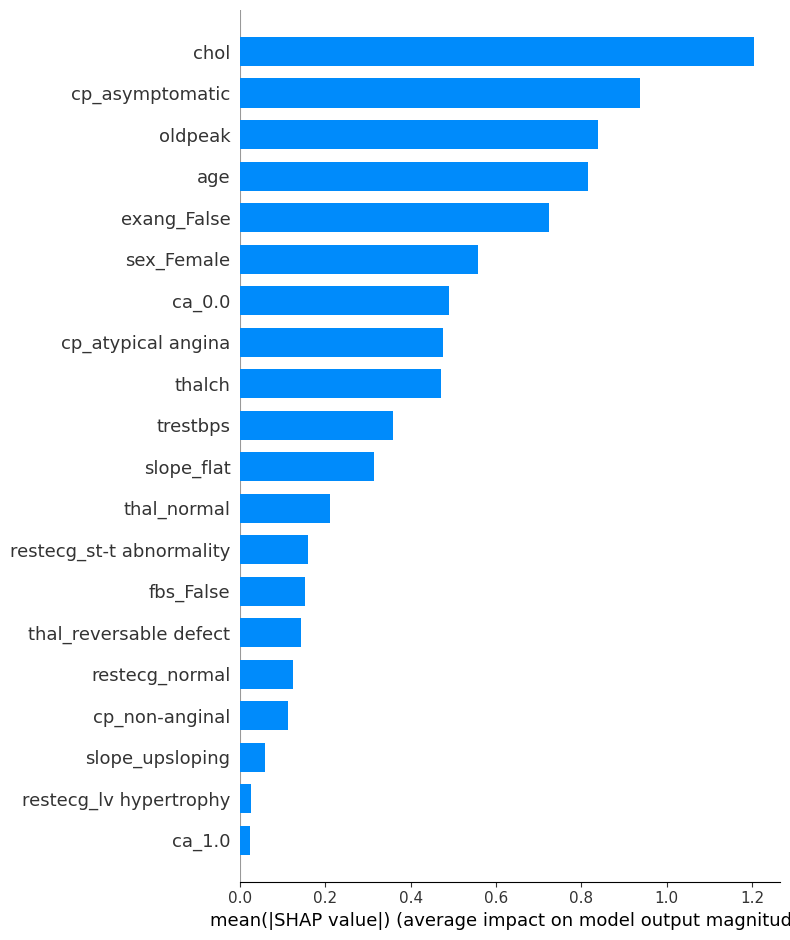

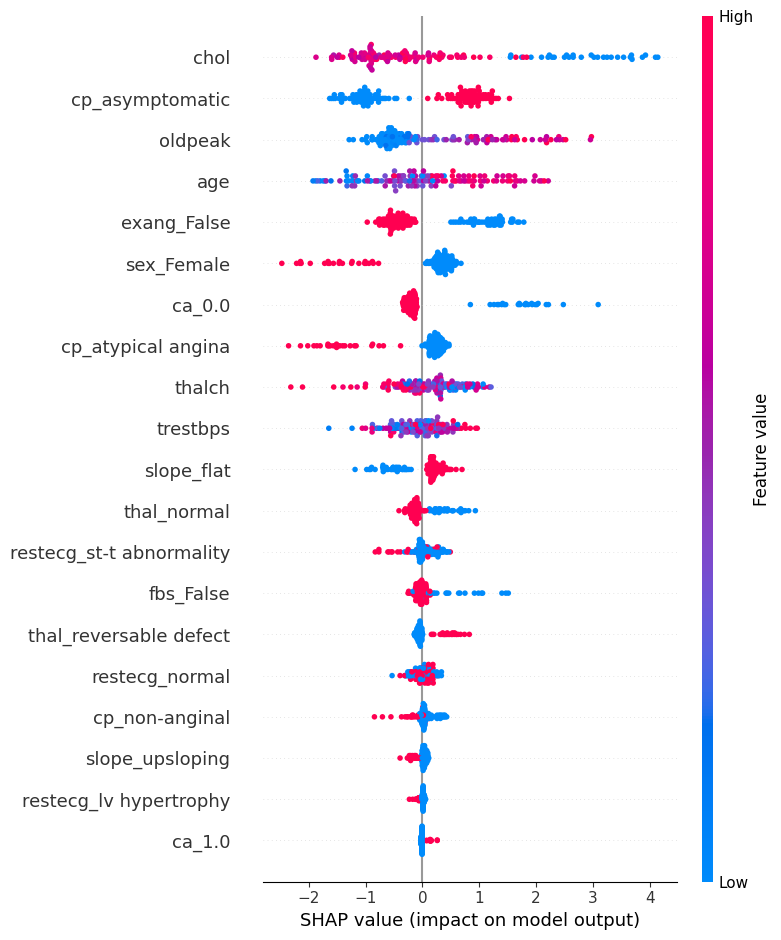

In [29]:
# Summary plot
shap.summary_plot(shap_values_xgb, X_test_df, plot_type="bar")  # Bar plot for feature importance
shap.summary_plot(shap_values_xgb, X_test_df)  # Beeswarm plot for SHAP values

  0%|          | 0/100 [00:00<?, ?it/s]

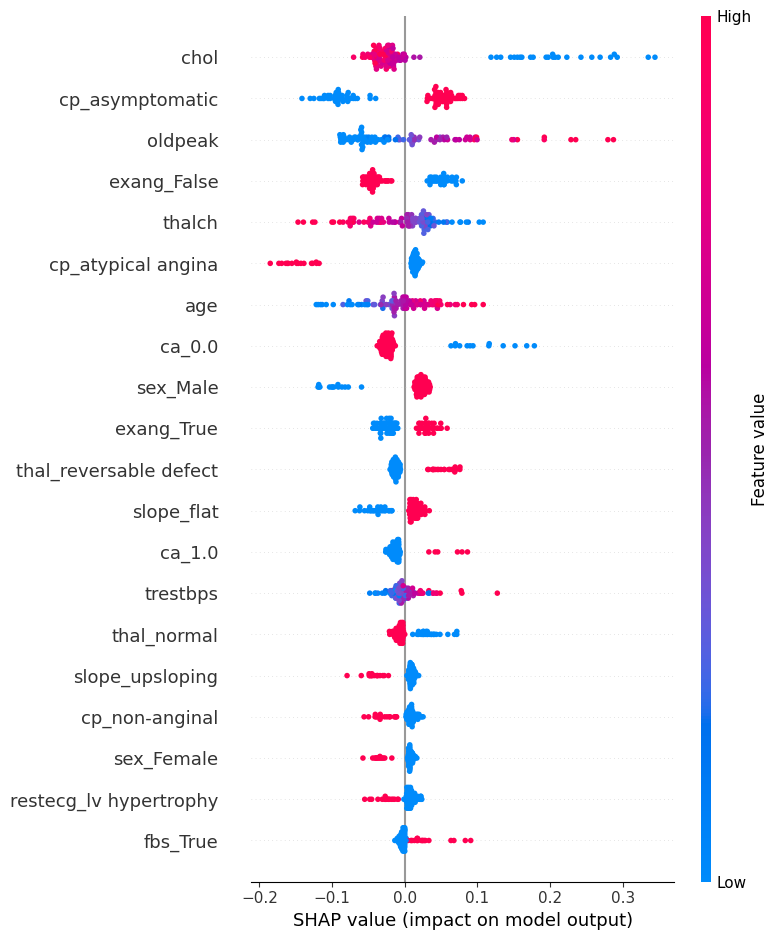

In [30]:
# For PyTorch model (slower, KernelExplainer)
try:
    # Small background sample for efficiency
    background = X_train_t[:50].toarray() if hasattr(X_train_t, 'toarray') else X_train_t[:50]
    test_sample = X_test_t[:100].toarray() if hasattr(X_test_t, 'toarray') else X_test_t[:100]

    def pytorch_predict(x):
        model.eval()
        xt = torch.tensor(x, dtype=torch.float32).to(DEVICE)
        with torch.no_grad():
            probs = model(xt).cpu().numpy().flatten()
        return probs

    explainer_kernel = shap.KernelExplainer(pytorch_predict, background)
    shap_values_pytorch = explainer_kernel.shap_values(test_sample)

    # Summary plot
    shap.summary_plot(shap_values_pytorch, pd.DataFrame(test_sample, columns=feature_names))
except Exception as e:
    print("SHAP for PyTorch failed or is too slow:", e)